# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.16/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


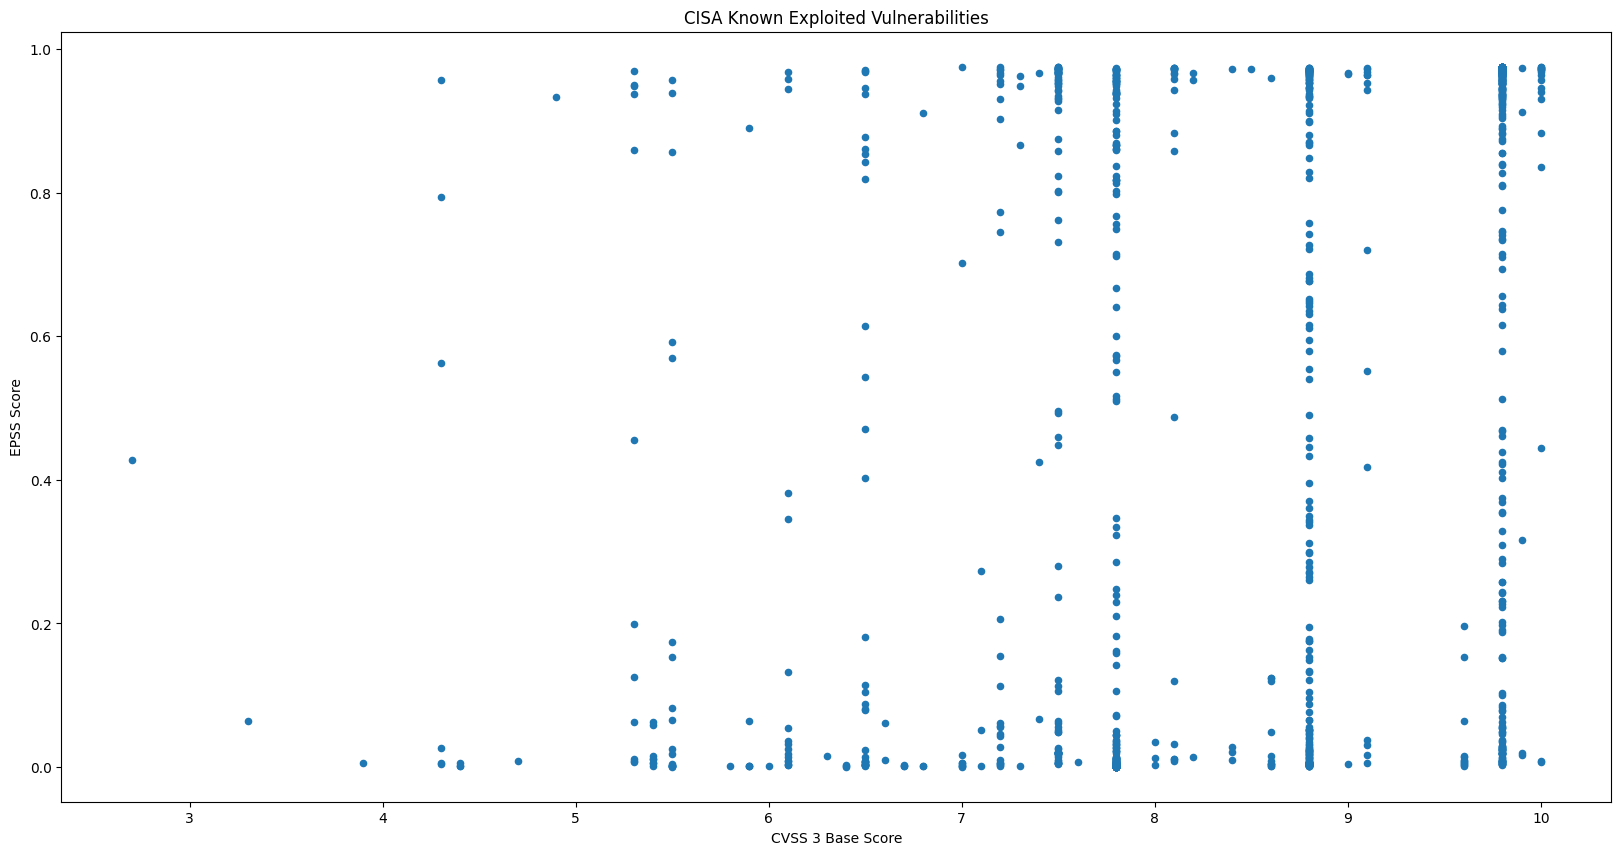

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CVS

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2020-11023,6.1,0.38151,0.97282,JQuery contains a persistent cross-site script...,JQuery,JQuery
1,CVE-2024-50603,9.8,0.88879,0.98992,Aviatrix Controllers contain an OS command inj...,Aviatrix,Controllers
2,CVE-2024-55591,9.8,0.02634,0.90176,Fortinet FortiOS and FortiProxy contain an aut...,Fortinet,FortiOS and FortiProxy
3,CVE-2023-48365,9.9,0.01658,0.87411,Qlik Sense contains an HTTP tunneling vulnerab...,Qlik,Sense
4,CVE-2024-12686,7.2,0.06180,0.93529,BeyondTrust Privileged Remote Access (PRA) and...,BeyondTrust,Privileged Remote Access (PRA) and Remote Supp...
5,CVE-2020-2883,9.8,0.96512,0.99731,"Oracle WebLogic Server, a product within the F...",Oracle,WebLogic Server
6,CVE-2024-55550,2.7,0.42716,0.97433,Mitel MiCollab contains a path traversal vulne...,Mitel,MiCollab
7,CVE-2024-41713,9.1,0.95267,0.99521,Mitel MiCollab contains a path traversal vulne...,Mitel,MiCollab
8,CVE-2024-3393,7.5,0.00783,0.81392,Palo Alto Networks PAN-OS contains a vulnerabi...,Palo Alto Networks,PAN-OS
9,CVE-2021-44207,8.1,0.00781,0.81368,Acclaim Systems USAHERDS contains a hard-coded...,Acclaim Systems,USAHERDS
